# Preprocessing

## Loading data / packages

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

RUN_PATH = "/media/floricslimani/SSD4To/SSD_floricslimani/Fish_seq/Davide/2024-09-03 - SeqFISH_Run8 - HeLa_POLR2"
# RUN_PATH = '/media/floricslimani/SSD4To/SSD_floricslimani/Fish_seq/Davide/2024-08-12 - SeqFISH - HeLa - Puro - R2TP1-2_Run7/'

OUTPUT_PATH = RUN_PATH + "/analysis/density/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [47]:
Acquisition = pd.read_feather(RUN_PATH + "/result_tables/Acquisition.feather")
Detection = pd.read_feather(RUN_PATH + "/result_tables/Detection.feather")
Spots = pd.read_feather(RUN_PATH + "/result_tables/Spots.feather")
Cell = pd.read_feather(RUN_PATH + "/result_tables/Cell.feather")
Gene_map = pd.read_feather(RUN_PATH + "/result_tables/Gene_map.feather")

In [48]:
if 'colocalisation_id' in Cell.columns and 'quantification_id' not in Cell.columns :
    Cell = Cell.rename(columns={'colocalisation_id' : 'quantification_id'})
elif 'colocalisation_id' in Cell.columns : raise AssertionError

In [49]:
check_len = len(Detection)
Detection = pd.merge(
    Detection,
    Acquisition.loc[:,['acquisition_id', 'cycle', 'location']],
    on= 'acquisition_id',
    suffixes=('','_acquisition')
)
assert len(Detection) == check_len

Detection = pd.merge(
    Detection,
    Gene_map.loc[:,['cycle','color_id','target']],
    on= ['cycle','color_id']
)
assert len(Detection) == check_len

check_len = len(Spots)
Spots = pd.merge(
    Spots,
    Detection.loc[:,['detection_id', 'acquisition_id', 'target', 'location']],
    on= 'detection_id'
)
assert len(Spots) == check_len

check_len = len(Cell)
Cell = pd.merge(
    Cell,
    Detection.loc[:,['detection_id', 'target']],
    on= 'detection_id'
)

assert len(Cell) == check_len

## Filtering Washout in Cell

In [50]:
updated_Cell = Cell.loc[~Cell['target'].str.contains('Washout')]

# Distribution per cell

Here we plot usual distributions of measure of interest such as number of RNA per cell...

In [51]:
updated_Cell.columns #all features already computed.

Index(['quantification_id', 'index_mean_distance_cell',
       'index_median_distance_cell', 'index_mean_distance_nuc',
       'index_median_distance_nuc', 'proportion_rna_in_nuc', 'nb_rna_out_nuc',
       'nb_rna_in_nuc', 'index_rna_protrusion', 'proportion_rna_protrusion',
       'protrusion_area', 'index_polarization', 'index_dispersion',
       'index_peripheral_distribution', 'index_rna_nuc_edge',
       'proportion_rna_nuc_edge', 'index_rna_nuc_radius_500_1000',
       'proportion_rna_nuc_radius_500_1000', 'index_rna_nuc_radius_1000_1500',
       'proportion_rna_nuc_radius_1000_1500', 'index_rna_nuc_radius_1500_2000',
       'proportion_rna_nuc_radius_1500_2000', 'index_rna_nuc_radius_2000_2500',
       'proportion_rna_nuc_radius_2000_2500', 'index_rna_nuc_radius_2500_3000',
       'proportion_rna_nuc_radius_2500_3000', 'index_rna_cell_radius_0_500',
       'proportion_rna_cell_radius_0_500', 'index_rna_cell_radius_500_1000',
       'proportion_rna_cell_radius_500_1000',
       '

In [52]:
from pbwrap.plot import distribution_super_plot

MEASURES = [
    'rna_number', 
    'cluster_number', 
    'proportion_rna_in_foci', 
    'nb_rna_in_nuc', 
    'index_mean_distance_nuc', 
    'index_mean_distance_cell'
    ]

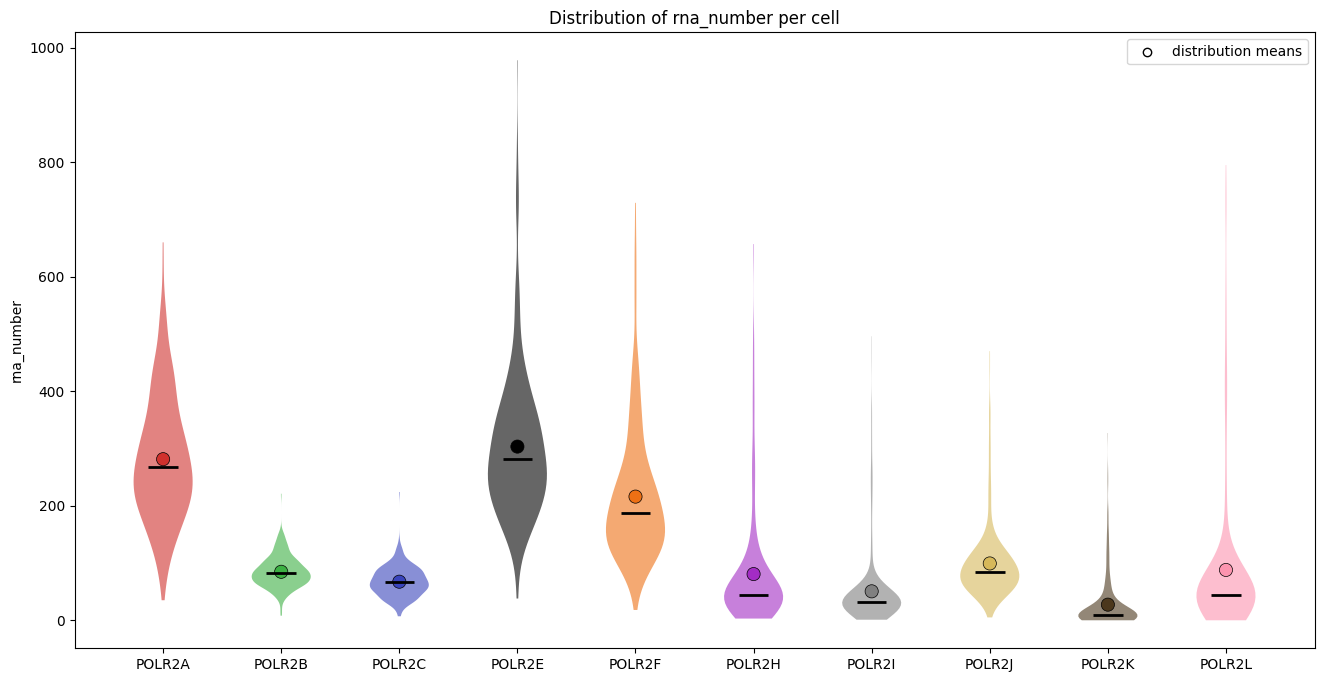

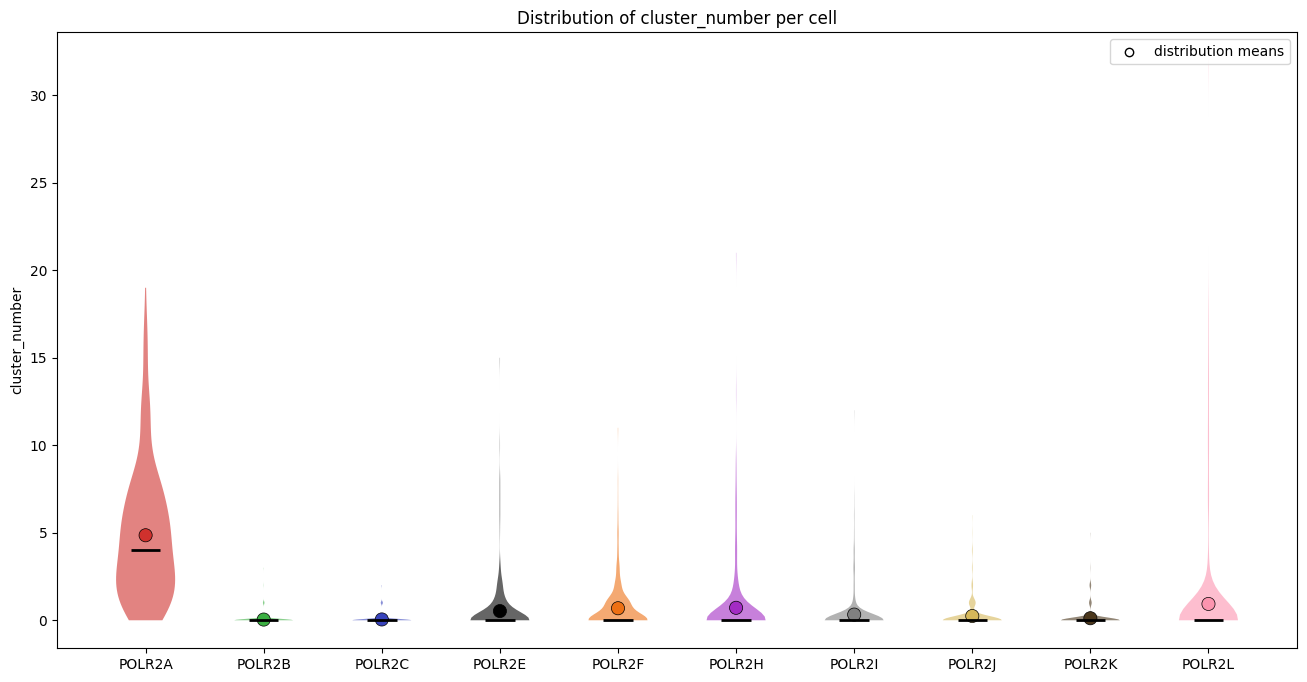

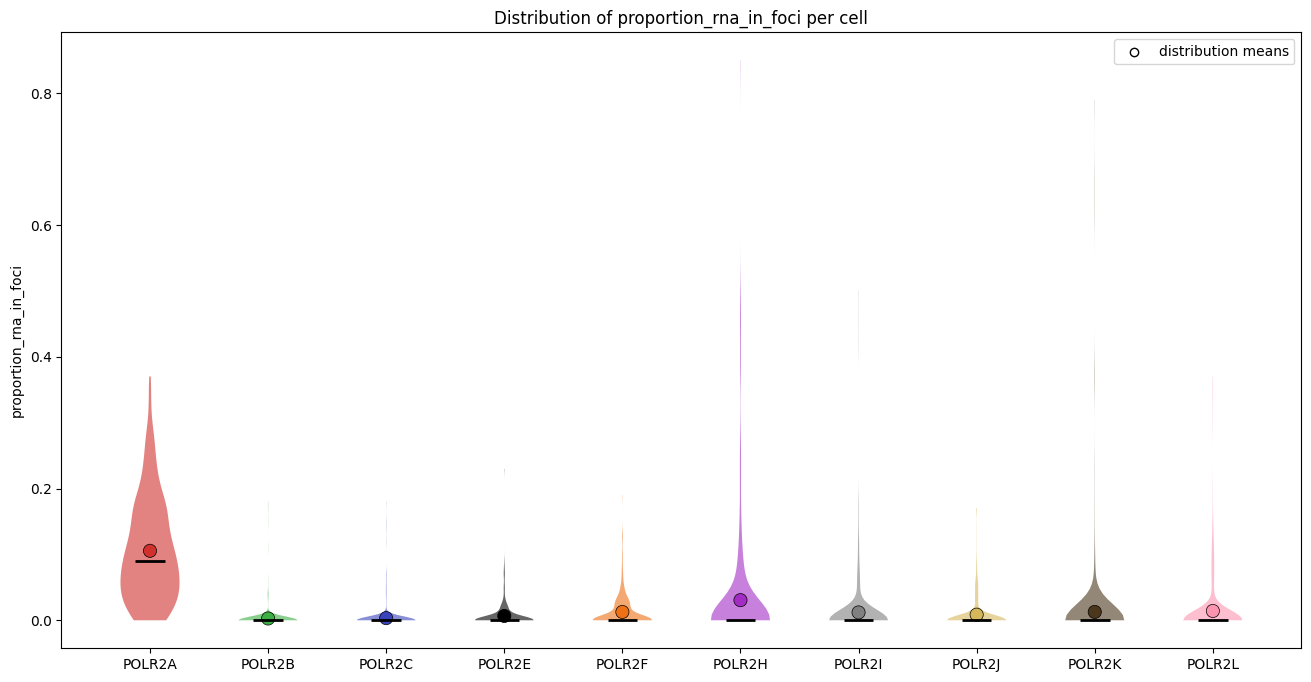

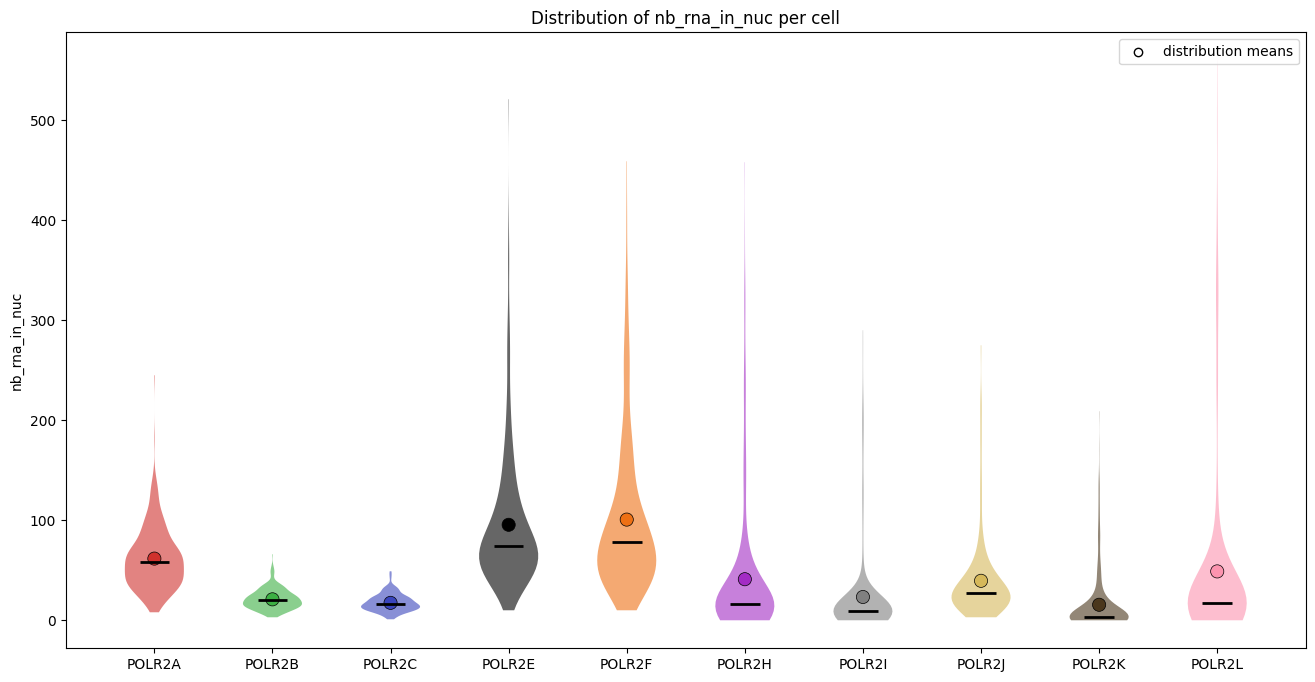

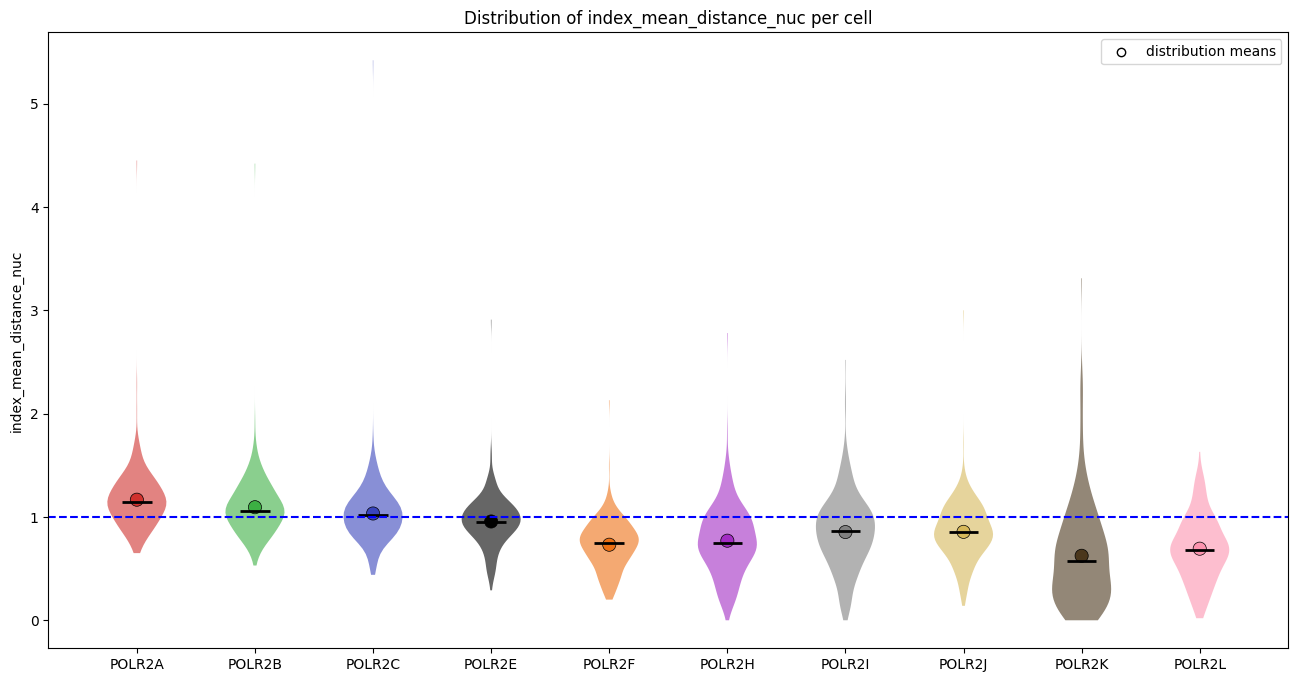

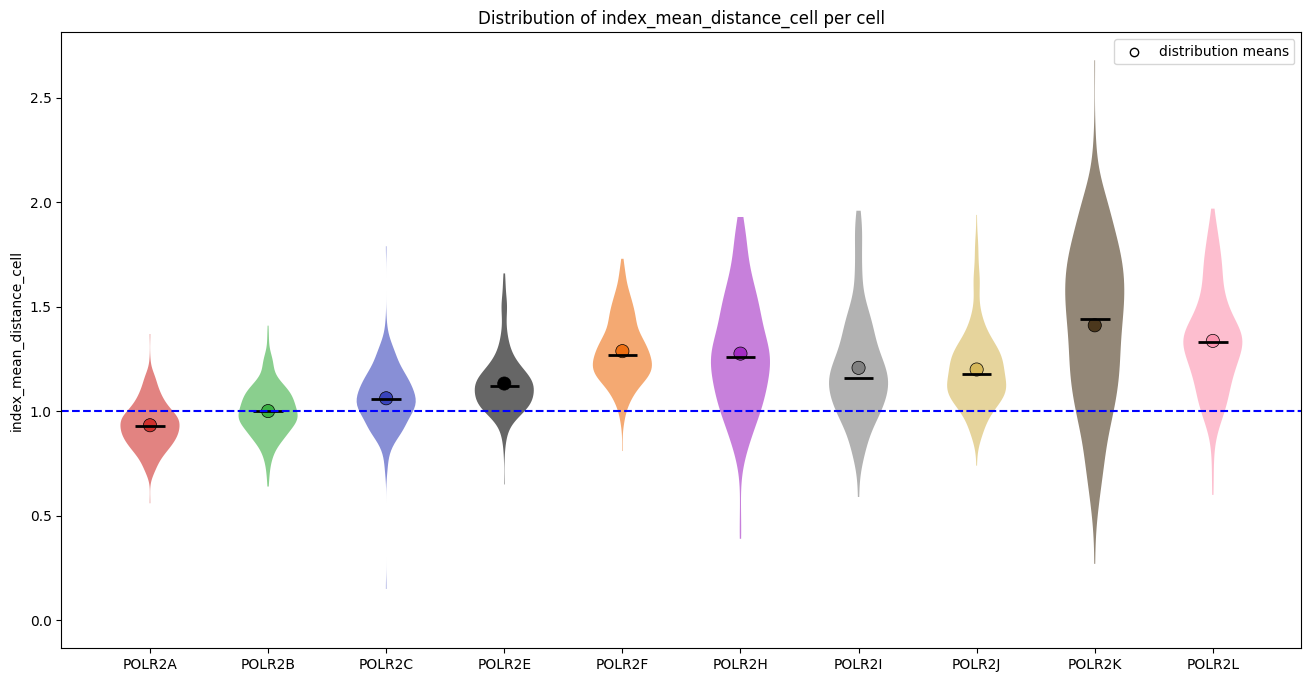

In [53]:
for measure in MEASURES :
    
    data = updated_Cell.groupby('target')[measure].apply(list)
    
    fig = plt.figure(figsize=(16,8))
    ax = fig.gca()
    ax = distribution_super_plot(
        data,
        ax,
        ylabel=measure,
        title= f"Distribution of {measure} per cell",
    )

    if 'index' in measure :
        min_x,max_x,min_y,max_y = plt.axis()
        ax.plot([min_x, max_x], [1,1], '--b')

plt.show()